In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)

# Import Mask RCNN

from confuse import utils
import mrcnn.model as modellib
from mrcnn import visualize
from samples.cdw import cdw


# To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
os.environ['CUDA_VISIBLE_DEVICES']='1'
# Local path to trained weights file
# CDW_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_cdw_0020.h5")
CDW_MODEL_PATH = 'E:/AI/fusion_model/logs/cdw20210123T1223/mask_rcnn_cdw_0120.h5'
# Directory of images to run detection on
#IMAGE_DIR = os.path.join("E:\DataSet\CDWdevkit\CDW2020\\Hyperspec_test14\\")
#IMAGE_DIR = os.path.join("E:\DataSet\CDWdevkit\CDW2020\\Image_test\\")
IMAGE_DIR = "E:/AI/20201203/val/image"



class InferenceConfig(cdw.CDWConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()

#%% md

## Create Model and Load Trained Weights

#%%

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=CDW_MODEL_PATH, config=config)

# Load weights trained on MS-COCO
model.load_weights(CDW_MODEL_PATH, by_name=True) #, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
#model.keras_model.save('mask_rcnn.h5')

class_names = ['BG','concrete','gray','red','wood','plaster','plastic','ceramic','carton']

# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
img_name = os.path.join(IMAGE_DIR, random.choice(file_names))
image = skimage.io.imread(img_name)
height_name = img_name.replace('/image', '/Height')
height = skimage.io.imread(height_name)
height = np.expand_dims(height, axis=-1)
image = np.concatenate([image, height], axis=-1)


print(image.shape)

# Run detection
import time
t1=time.clock()
results = model.detect([image], verbose=1)
print("time:",time.clock()-t1)
# Visualize results
r = results[0][0]


# print(image[:,:,:3])
# print(r['rois'])
# print(r['masks'], r['class_ids'])
# print(class_names)
visualize.display_instances(image[:,:,:3], r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])
# print( r['class_ids'])

# Validation dataset
dataset_root='E:/AI/20201203'
dataset= cdw.CDWDataset()
#dataset.load_cdw(dataset_root, json_dir="Annotation",img_dir='Hyperspec_',hyper=True)
#dataset.load_cdw(dataset_root, json_dir="Annotation",img_dir=None,hyper=False)
dataset.load_cdw(dataset_root, "val")
dataset.prepare()
print('val data prepared')

import imgaug
import time
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    AP50s = []
    AP75s = []
    #ground-truth and predictions lists
    gt_tot = np.array([])
    pred_tot = np.array([])
    count = 0
    for image_id in image_ids:
        # Load image
        print(count)
        count+=1
        image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset, config,
                                   image_id,
                                   use_mini_mask=False,

                                   )
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0][0]

        #compute gt_tot and pred_tot
        gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
        gt_tot = np.append(gt_tot, gt)
        pred_tot = np.append(pred_tot, pred)
        #check if the vectors len are equal
        # print("the actual len of the gt vect is : ", len(gt_tot))
        # print("the actual len of the pred vect is : ", len(pred_tot))
        # print("Ground truth object : "+dataset.class_names[gt])
        # print("Predicted object : "+dataset.class_names[pred])

        # visualize.display_instances(image[:,:,:3], r['rois'], r['masks'], r['class_ids'],
        #                     class_names, r['scores'])
        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r['rois'], r['class_ids'], r['scores'], r['masks'], 0.75)
        #confuse[gt_class_id[:],r['class_ids'][:]]+=1
        AP75s.append(AP)

        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r['rois'], r['class_ids'], r['scores'], r['masks'], 0.5)
        #confuse[gt_class_id[:],r['class_ids'][:]]+=1
        AP50s.append(AP)
    print("测试数量",len(AP50s))
    gt_tot=gt_tot.astype(int)
    pred_tot=pred_tot.astype(int)

    return AP50s, AP75s,gt_tot,pred_tot
AP50s, AP75s,gt_tot,pred_tot = compute_batch_ap(dataset.image_ids)
save_dir = "E:/AI/fusion_model/confuse"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
#%%

image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset, config,
                           dataset.image_ids[1], use_mini_mask=False)
results = model.detect([image], verbose=0)
t1=time.clock()
utils.compute_overlaps_masks(gt_mask,results[0][0]['masks'])
print("计算mask iou时间",time.clock()-t1)

#%%

a=dataset.image_ids
mAp=np.nanmean(AP50s)
print("mAP @ IoU=50: ", mAp)
mAp=np.nanmean(AP75s)
print("mAP @ IoU=75: ", mAp)

Using TensorFlow backend.

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

<Figure size 1600x1600 with 1 Axes>

loading val data 1 /  18
loading val data 2 /  18
loading val data 3 /  18
loading val data 4 /  18
loading val data 5 /  18
loading val data 6 /  18
loading val data 7 /  18
loading val data 8 /  18
loading val data 9 /  18
loading val data 10 /  18
loading val data 11 /  18
loading val data 12 /  18
loading val data 13 /  18
loading val data 14 /  18
loading val data 15 /  18
loading val data 16 /  18
loading val data 17 /  18
loading val data 18 /  18
val data prepared
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
测试数量 18
计算mask iou时间 0.022692899999995575
mAP @ IoU=50:  0.9706790118857666
mAP @ IoU=75:  0.9452160500265934


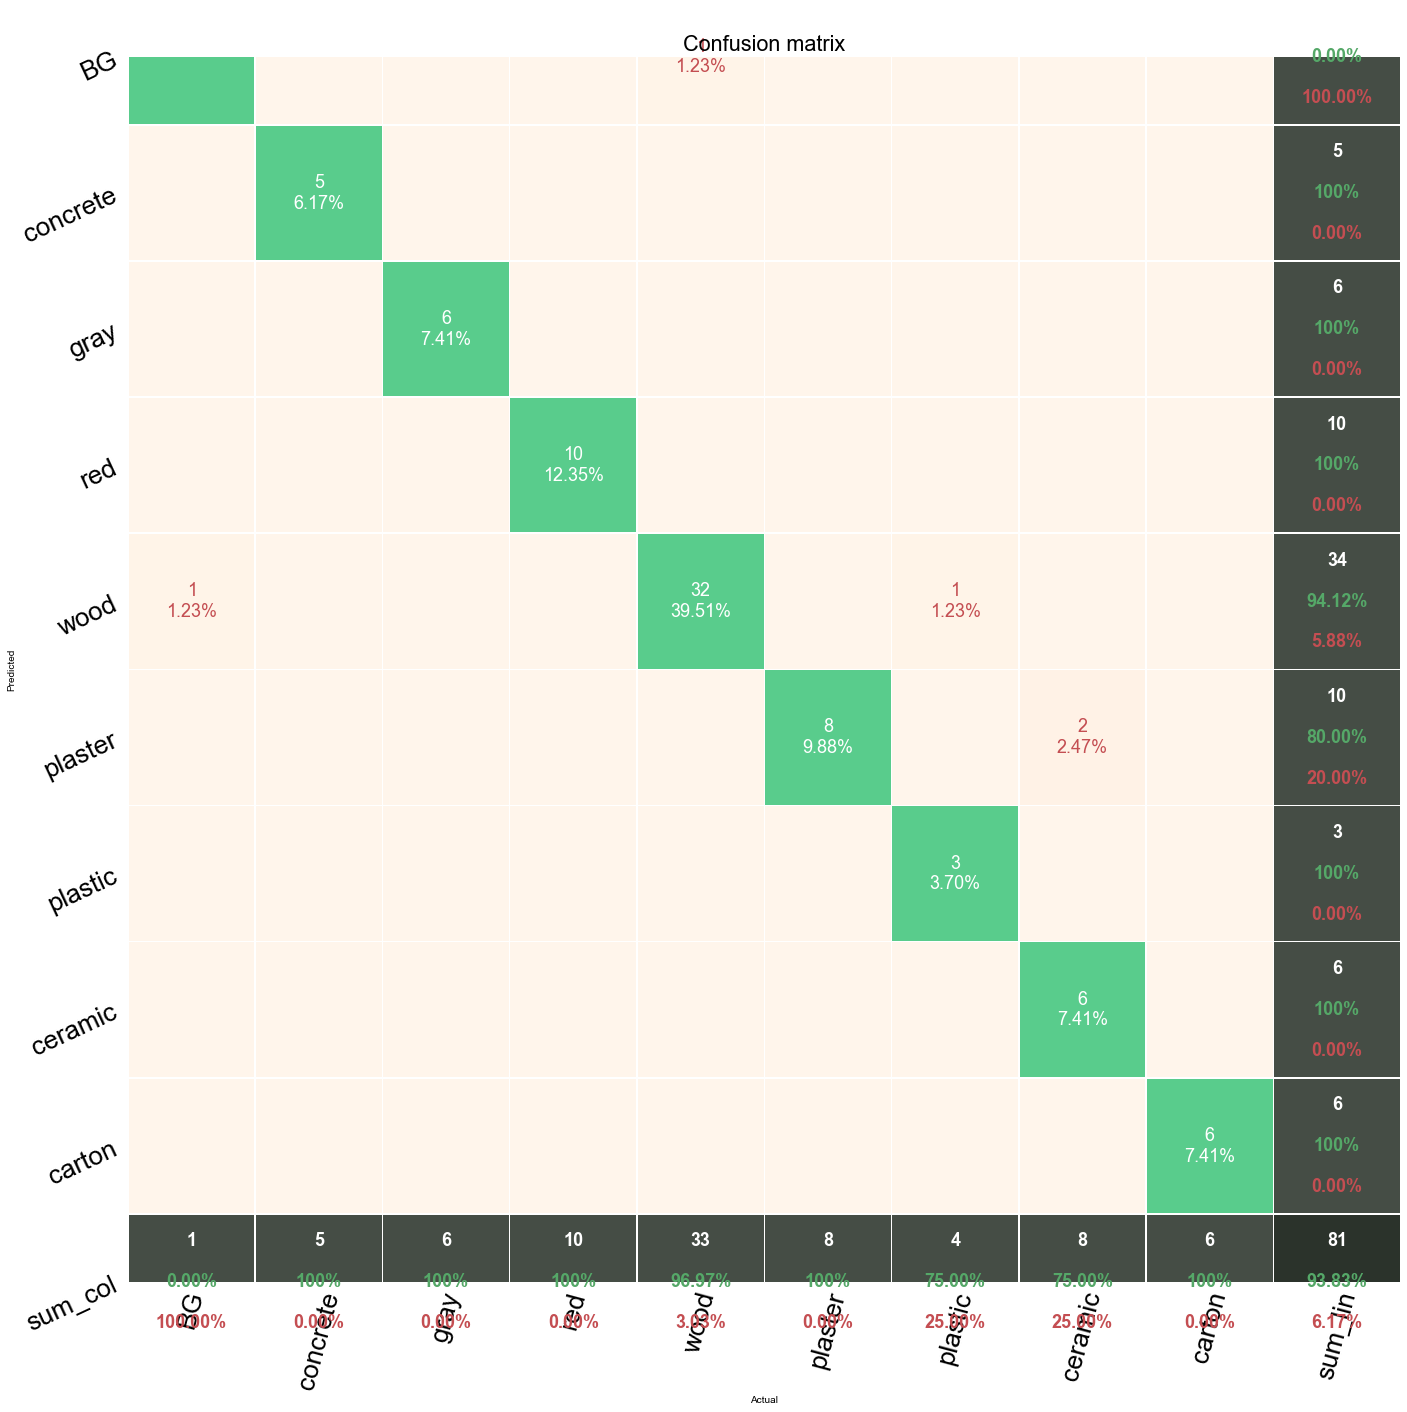

In [2]:
tp, fp, fn = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)